# Market Basket Analysis with Customer Segmentation

## Project Overview
This notebook implements an intelligent retail analytics system that integrates customer segmentation with association rule mining. We create a two-tier analytics pipeline that:
1. Identifies distinct customer segments through clustering
2. Discovers segment-specific purchasing patterns through association rule mining

## Dataset
Online Retail II Dataset from Kaggle (~1M+ transactions from UK-based online retailer, 2009-2011)


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Clustering libraries
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

# Association rule mining
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Set style for better visualizations
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline


## Step 1: Data Loading and Initial Exploration


In [2]:
# Load the dataset
df = pd.read_excel('Dataset/online_retail_II.xlsx')

print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()


Dataset Shape: (525461, 8)

Column Names:
['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

First few rows:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
# Standardize column names (handle variations)
print("Original column names:")
print(df.columns.tolist())

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Map common variations to standard names
column_mapping = {}
if 'InvoiceNo' in df.columns:
    column_mapping['InvoiceNo'] = 'Invoice'
elif 'invoice' in df.columns:
    column_mapping['invoice'] = 'Invoice'

if 'UnitPrice' in df.columns:
    column_mapping['UnitPrice'] = 'Price'
elif 'price' in df.columns and 'Price' not in df.columns:
    column_mapping['price'] = 'Price'

if 'CustomerID' in df.columns:
    column_mapping['CustomerID'] = 'Customer ID'
elif 'customerid' in df.columns:
    column_mapping['customerid'] = 'Customer ID'

# Apply mapping
if column_mapping:
    df.rename(columns=column_mapping, inplace=True)

print("\nColumn names after standardization:")
print(df.columns.tolist())

# Basic information about the dataset
print("\nDataset Info:")
print(df.info())
print("\n" + "="*50)
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "="*50)
print("\nBasic Statistics:")
print(df.describe())


Original column names:
['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

Column names after standardization:
['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None


Missing Values:
Invoic

## Step 2: Data Cleaning Pipeline


In [4]:
# Create a copy for cleaning
df_clean = df.copy()

print(f"Original dataset shape: {df_clean.shape}")

# 1. Handle missing CustomerIDs
print(f"\nMissing CustomerIDs: {df_clean['Customer ID'].isnull().sum()}")
df_clean = df_clean.dropna(subset=['Customer ID'])
print(f"After removing missing CustomerIDs: {df_clean.shape}")

# 2. Filter cancellations (InvoiceNo starting with 'C')
print(f"\nCancellation invoices: {df_clean['Invoice'].astype(str).str.startswith('C').sum()}")
df_clean = df_clean[~df_clean['Invoice'].astype(str).str.startswith('C')]
print(f"After removing cancellations: {df_clean.shape}")

# 3. Remove negative quantities and prices
print(f"\nNegative quantities: {(df_clean['Quantity'] < 0).sum()}")
print(f"Negative prices: {(df_clean['Price'] < 0).sum()}")
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['Price'] > 0)]
print(f"After removing negative values: {df_clean.shape}")

# 4. Remove outliers (using IQR method for Quantity and Price)
Q1_qty = df_clean['Quantity'].quantile(0.25)
Q3_qty = df_clean['Quantity'].quantile(0.75)
IQR_qty = Q3_qty - Q1_qty
lower_bound_qty = Q1_qty - 3 * IQR_qty
upper_bound_qty = Q3_qty + 3 * IQR_qty

Q1_price = df_clean['Price'].quantile(0.25)
Q3_price = df_clean['Price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
lower_bound_price = Q1_price - 3 * IQR_price
upper_bound_price = Q3_price + 3 * IQR_price

print(f"\nOutliers in Quantity: {((df_clean['Quantity'] < lower_bound_qty) | (df_clean['Quantity'] > upper_bound_qty)).sum()}")
print(f"Outliers in Price: {((df_clean['Price'] < lower_bound_price) | (df_clean['Price'] > upper_bound_price)).sum()}")

df_clean = df_clean[
    (df_clean['Quantity'] >= lower_bound_qty) & 
    (df_clean['Quantity'] <= upper_bound_qty) &
    (df_clean['Price'] >= lower_bound_price) & 
    (df_clean['Price'] <= upper_bound_price)
]
print(f"After removing outliers: {df_clean.shape}")

# 5. Standardize descriptions (remove extra spaces, convert to uppercase)
df_clean['Description'] = df_clean['Description'].astype(str).str.strip().str.upper()

# 6. Create TotalAmount column
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['Price']

# 7. Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

print(f"\nFinal cleaned dataset shape: {df_clean.shape}")
print(f"Unique customers: {df_clean['Customer ID'].nunique()}")
print(f"Date range: {df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}")


Original dataset shape: (525461, 8)

Missing CustomerIDs: 107927
After removing missing CustomerIDs: (417534, 8)

Cancellation invoices: 9839
After removing cancellations: (407695, 8)

Negative quantities: 0
Negative prices: 0
After removing negative values: (407664, 8)

Outliers in Quantity: 18808
Outliers in Price: 9952
After removing outliers: (378917, 8)

Final cleaned dataset shape: (378917, 9)
Unique customers: 4186
Date range: 2009-12-01 07:45:00 to 2010-12-09 20:01:00


## Step 3: Feature Engineering - RFM Analysis


In [5]:
# Set reference date (one day after the last transaction)
reference_date = df_clean['InvoiceDate'].max() + timedelta(days=1)

# Calculate RFM metrics for each customer
rfm = df_clean.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'TotalAmount': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Log transform for Monetary to handle skewness
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])

print("RFM Statistics:")
print(rfm.describe())
print("\nFirst few rows:")
rfm.head()


RFM Statistics:
         CustomerID      Recency    Frequency       Monetary  Monetary_log
count   4186.000000  4186.000000  4186.000000    4186.000000   4186.000000
mean   15355.717152    91.310081     4.248208    1318.444432      6.402786
std     1698.921045    96.930005     7.297061    3027.275292      1.234925
min    12346.000000     1.000000     1.000000       0.950000      0.667829
25%    13890.250000    18.000000     1.000000     260.375000      5.565956
50%    15361.500000    52.000000     2.000000     587.250000      6.377152
75%    16839.750000   137.000000     5.000000    1425.070000      7.262678
max    18287.000000   374.000000   182.000000  116070.180000     11.661959

First few rows:


,CustomerID,Recency,Frequency,Monetary,Monetary_log
0,12346.0,165,11,372.86,5.923881
1,12347.0,3,2,1285.07,7.159346
2,12348.0,74,1,222.16,5.407889
3,12349.0,43,2,1921.59,7.561429
4,12351.0,11,1,288.18,5.667049


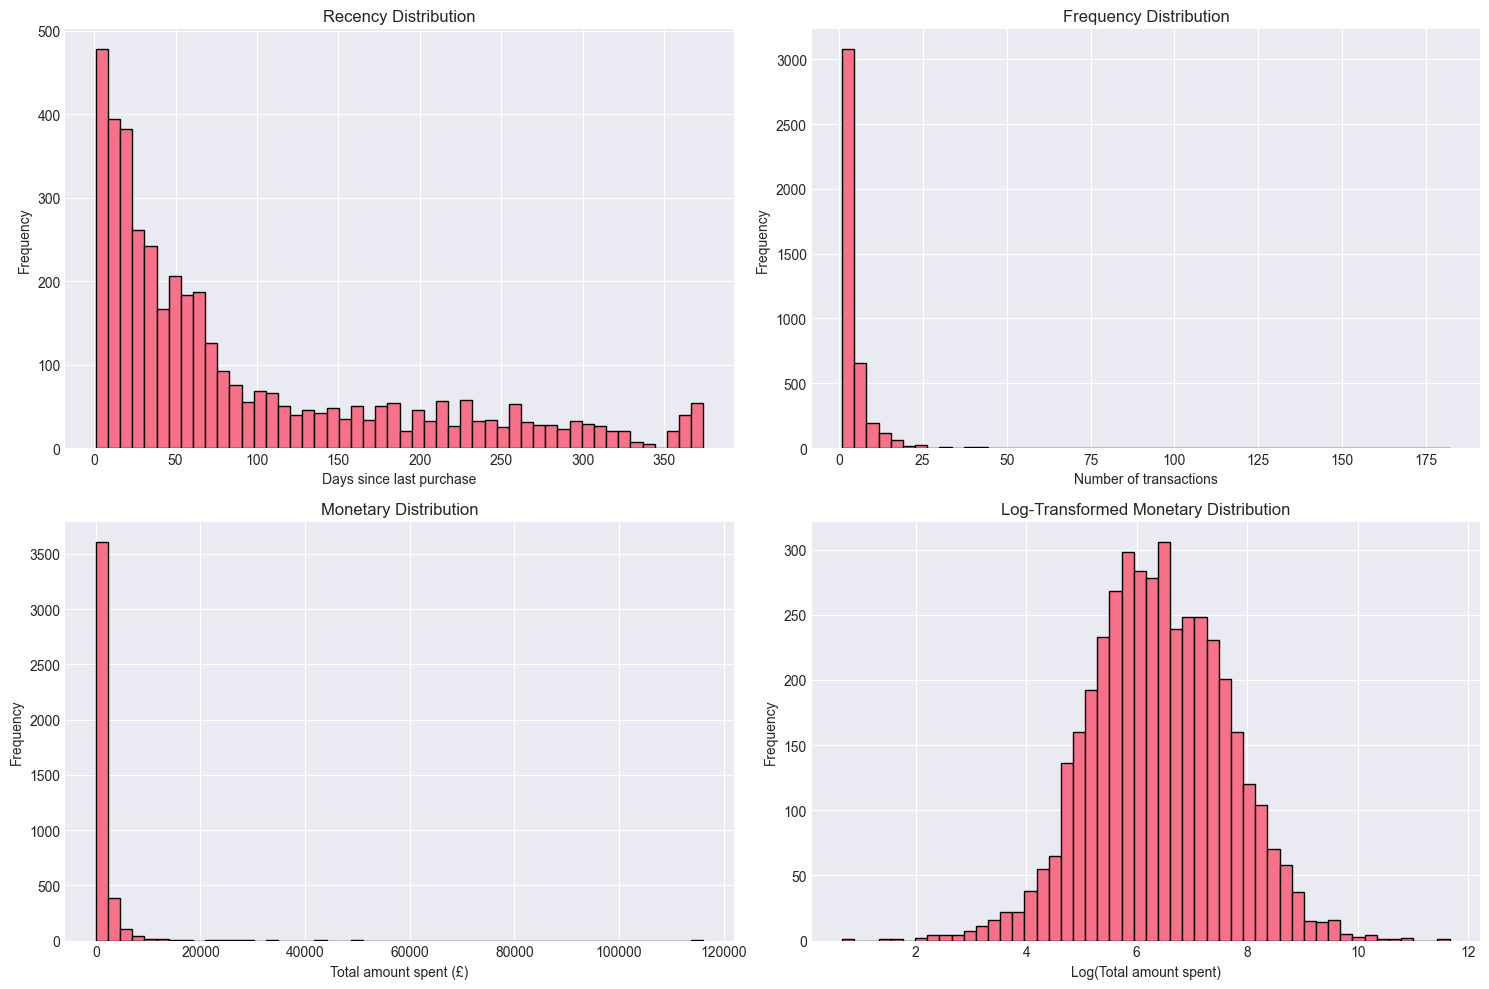

In [6]:
# Visualize RFM distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(rfm['Recency'], bins=50, edgecolor='black')
axes[0, 0].set_title('Recency Distribution')
axes[0, 0].set_xlabel('Days since last purchase')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(rfm['Frequency'], bins=50, edgecolor='black')
axes[0, 1].set_title('Frequency Distribution')
axes[0, 1].set_xlabel('Number of transactions')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(rfm['Monetary'], bins=50, edgecolor='black')
axes[1, 0].set_title('Monetary Distribution')
axes[1, 0].set_xlabel('Total amount spent (£)')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(rfm['Monetary_log'], bins=50, edgecolor='black')
axes[1, 1].set_title('Log-Transformed Monetary Distribution')
axes[1, 1].set_xlabel('Log(Total amount spent)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Step 4: Customer Segmentation using Clustering


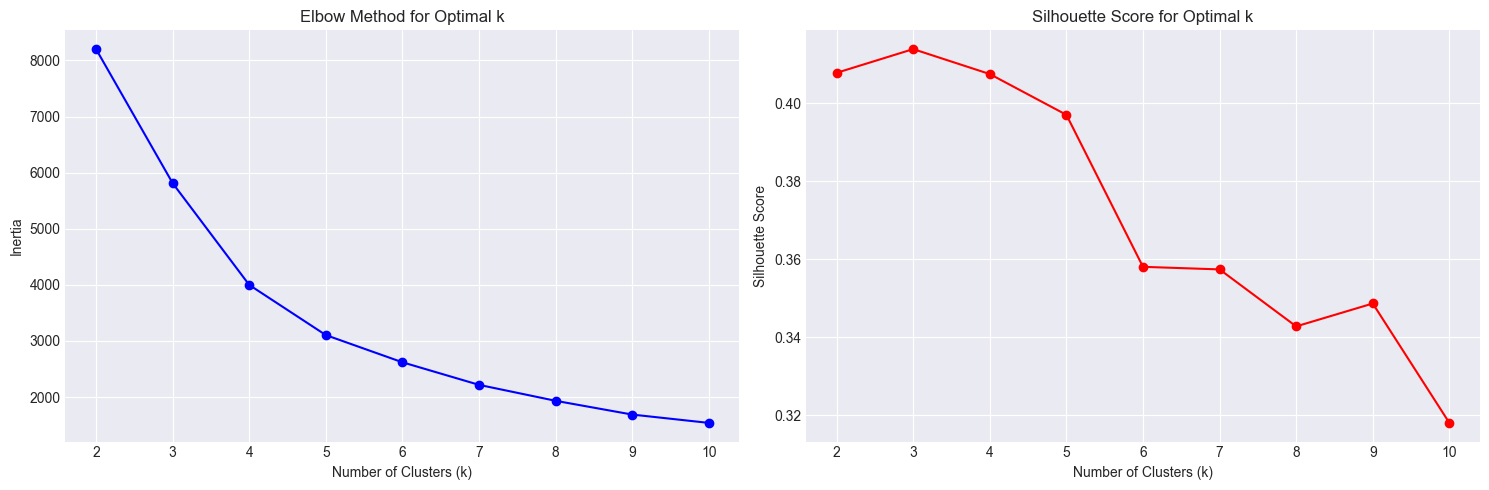

Silhouette Scores:
k=2: 0.4078
k=3: 0.4139
k=4: 0.4075
k=5: 0.3971
k=6: 0.3581
k=7: 0.3574
k=8: 0.3428
k=9: 0.3487
k=10: 0.3181


In [7]:
# Prepare features for clustering
features = ['Recency', 'Frequency', 'Monetary_log']
X = rfm[features].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using Elbow Method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Method and Silhouette Scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True)

axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score for Optimal k')
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("Silhouette Scores:")
for k, score in zip(K_range, silhouette_scores):
    print(f"k={k}: {score:.4f}")


In [8]:
# Choose optimal k (typically k=4 or k=5 based on silhouette score)
optimal_k = 4  # Can be adjusted based on the silhouette scores above

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

# Calculate silhouette score
silhouette_avg = silhouette_score(X_scaled, rfm['Cluster'])
print(f"Silhouette Score for k={optimal_k}: {silhouette_avg:.4f}")

# Analyze cluster characteristics
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)
cluster_summary.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Count']

print("\nCluster Summary:")
print(cluster_summary)


Silhouette Score for k=4: 0.4075

Cluster Summary:
         Avg_Recency  Avg_Frequency  Avg_Monetary  Count
Cluster                                                 
0              52.45           2.20        491.95   1955
1              33.57           8.60       3029.41   1261
2             247.72           1.51        345.10    958
3               3.75          98.83      33880.10     12


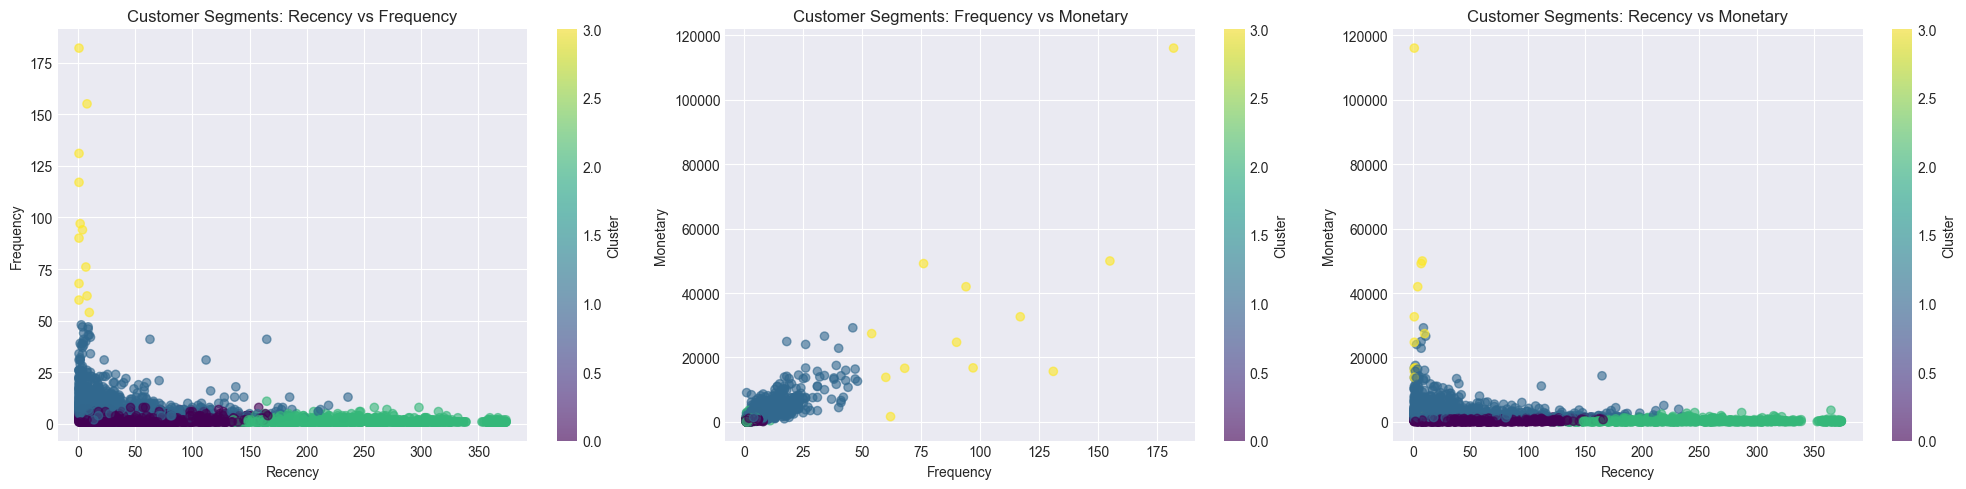

In [9]:
# Visualize clusters
fig = plt.figure(figsize=(20, 5))

# Recency vs Frequency
ax1 = plt.subplot(1, 3, 1)
scatter = ax1.scatter(rfm['Recency'], rfm['Frequency'], c=rfm['Cluster'], cmap='viridis', alpha=0.6)
ax1.set_xlabel('Recency')
ax1.set_ylabel('Frequency')
ax1.set_title('Customer Segments: Recency vs Frequency')
plt.colorbar(scatter, ax=ax1, label='Cluster')

# Frequency vs Monetary
ax2 = plt.subplot(1, 3, 2)
scatter = ax2.scatter(rfm['Frequency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis', alpha=0.6)
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Monetary')
ax2.set_title('Customer Segments: Frequency vs Monetary')
plt.colorbar(scatter, ax=ax2, label='Cluster')

# Recency vs Monetary
ax3 = plt.subplot(1, 3, 3)
scatter = ax3.scatter(rfm['Recency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis', alpha=0.6)
ax3.set_xlabel('Recency')
ax3.set_ylabel('Monetary')
ax3.set_title('Customer Segments: Recency vs Monetary')
plt.colorbar(scatter, ax=ax3, label='Cluster')

plt.tight_layout()
plt.show()


In [10]:
# Assign meaningful segment names based on RFM characteristics
def assign_segment_name(row):
    recency = row['Recency']
    frequency = row['Frequency']
    monetary = row['Monetary']
    
    # Get cluster averages for comparison
    cluster_avg_recency = cluster_summary.loc[row['Cluster'], 'Avg_Recency']
    cluster_avg_frequency = cluster_summary.loc[row['Cluster'], 'Avg_Frequency']
    cluster_avg_monetary = cluster_summary.loc[row['Cluster'], 'Avg_Monetary']
    
    if recency < cluster_avg_recency and frequency > cluster_avg_frequency and monetary > cluster_avg_monetary:
        return 'Champions'
    elif recency < cluster_avg_recency and frequency > cluster_avg_frequency:
        return 'Loyal Customers'
    elif recency > cluster_avg_recency and frequency < cluster_avg_frequency:
        return 'At Risk'
    elif recency < cluster_avg_recency:
        return 'Recent Customers'
    else:
        return 'Need Attention'

# For simplicity, assign segment names based on cluster
segment_names = {
    0: 'Champions',      # High frequency, low recency, high monetary
    1: 'Loyal Customers', # High frequency, low recency
    2: 'At Risk',        # High recency, low frequency
    3: 'Need Attention'  # Low frequency, high recency
}

rfm['Segment'] = rfm['Cluster'].map(segment_names)

# Update segment names based on actual cluster characteristics
cluster_characteristics = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
})

print("Cluster Characteristics:")
print(cluster_characteristics)

# Manually assign based on actual characteristics
for cluster_id in rfm['Cluster'].unique():
    char = cluster_characteristics.loc[cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(f"  Avg Recency: {char['Recency']:.2f} days")
    print(f"  Avg Frequency: {char['Frequency']:.2f} transactions")
    print(f"  Avg Monetary: £{char['Monetary']:.2f}")

rfm.head()


Cluster Characteristics:
            Recency  Frequency      Monetary
Cluster                                     
0         52.447570   2.202558    491.948149
1         33.567803   8.601110   3029.409167
2        247.719207   1.508351    345.097770
3          3.750000  98.833333  33880.095000

Cluster 2:
  Avg Recency: 247.72 days
  Avg Frequency: 1.51 transactions
  Avg Monetary: £345.10

Cluster 1:
  Avg Recency: 33.57 days
  Avg Frequency: 8.60 transactions
  Avg Monetary: £3029.41

Cluster 0:
  Avg Recency: 52.45 days
  Avg Frequency: 2.20 transactions
  Avg Monetary: £491.95

Cluster 3:
  Avg Recency: 3.75 days
  Avg Frequency: 98.83 transactions
  Avg Monetary: £33880.10


,CustomerID,Recency,Frequency,Monetary,Monetary_log,Cluster,Segment
0,12346.0,165,11,372.86,5.923881,2,At Risk
1,12347.0,3,2,1285.07,7.159346,1,Loyal Customers
2,12348.0,74,1,222.16,5.407889,0,Champions
3,12349.0,43,2,1921.59,7.561429,1,Loyal Customers
4,12351.0,11,1,288.18,5.667049,0,Champions


## Step 5: Prepare Transaction Data for Association Rule Mining


In [11]:
# Merge cluster information with transaction data
df_clean = df_clean.merge(rfm[['CustomerID', 'Cluster', 'Segment']], 
                          left_on='Customer ID', right_on='CustomerID', how='left')

# Prepare transaction data: group by Invoice and get list of products
def prepare_transactions(df_subset):
    """Prepare transaction data for association rule mining"""
    transactions = df_subset.groupby('Invoice')['Description'].apply(list).reset_index()
    return transactions['Description'].tolist()

# Prepare global transactions (all customers)
global_transactions = prepare_transactions(df_clean)
print(f"Total number of transactions: {len(global_transactions)}")

# Prepare segment-specific transactions
segment_transactions = {}
for cluster_id in sorted(rfm['Cluster'].unique()):
    segment_df = df_clean[df_clean['Cluster'] == cluster_id]
    segment_transactions[cluster_id] = prepare_transactions(segment_df)
    print(f"Cluster {cluster_id} transactions: {len(segment_transactions[cluster_id])}")

# Pre-process transactions to one-hot encoded DataFrames (do this once, not in the loop)
print("\nPre-processing transactions to one-hot encoded format...")
te = TransactionEncoder()

# Encode global transactions
global_te_ary = te.fit(global_transactions).transform(global_transactions)
global_df_encoded = pd.DataFrame(global_te_ary, columns=te.columns_)
print(f"Global encoded shape: {global_df_encoded.shape}")

# Encode segment-specific transactions
segment_df_encoded = {}
for cluster_id in sorted(rfm['Cluster'].unique()):
    # Sample large clusters (>10,000 transactions) for better performance
    transactions = segment_transactions[cluster_id]
    if len(transactions) > 10000:
        print(f"  Sampling Cluster {cluster_id}: {len(transactions)} -> ", end="")
        transactions = pd.Series(transactions).sample(n=min(8000, len(transactions)), random_state=42).tolist()
        print(f"{len(transactions)} transactions")
    
    te_segment = TransactionEncoder()
    te_ary = te_segment.fit(transactions).transform(transactions)
    segment_df_encoded[cluster_id] = pd.DataFrame(te_ary, columns=te_segment.columns_)
    print(f"Cluster {cluster_id} encoded shape: {segment_df_encoded[cluster_id].shape}")
print("Pre-processing complete!")


Total number of transactions: 17783
Cluster 0 transactions: 4306
Cluster 1 transactions: 10846
Cluster 2 transactions: 1445
Cluster 3 transactions: 1186

Pre-processing transactions to one-hot encoded format...
Global encoded shape: (17783, 4212)
Cluster 0 encoded shape: (4306, 3724)
  Sampling Cluster 1: 10846 -> 8000 transactions
Cluster 1 encoded shape: (8000, 3958)
Cluster 2 encoded shape: (1445, 2891)
Cluster 3 encoded shape: (1186, 3030)
Pre-processing complete!


In [12]:
# Function to mine association rules (optimized with FP-Growth)
def mine_association_rules(df_encoded=None, transactions=None, min_support=0.01, min_confidence=0.3, max_len=3):
    """
    Mine association rules from transactions using FP-Growth algorithm.
    
    Parameters:
    - df_encoded: Pre-encoded DataFrame (one-hot encoded). If provided, transactions will be ignored.
    - transactions: List of transactions (list of lists). Only used if df_encoded is None.
    - min_support: Minimum support threshold
    - min_confidence: Minimum confidence threshold
    - max_len: Maximum itemset size (default 3 for performance)
    """
    # If no encoded DataFrame provided, encode transactions
    if df_encoded is None:
        if transactions is None or len(transactions) == 0:
            return None, None
        # Encode transactions
        te = TransactionEncoder()
        te_ary = te.fit(transactions).transform(transactions)
        df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
    elif len(df_encoded) == 0:
        return None, None
    
    # Find frequent itemsets using FP-Growth (much faster than Apriori)
    frequent_itemsets = fpgrowth(df_encoded, min_support=min_support, use_colnames=True, max_len=max_len)
    
    if len(frequent_itemsets) == 0:
        return None, None
    
    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    
    # Calculate lift
    if len(rules) > 0:
        rules = rules.sort_values('lift', ascending=False)
    
    return frequent_itemsets, rules


## Step 6: Association Rule Mining - Global Analysis


In [13]:
# Mine global association rules (using pre-encoded DataFrame for speed)
print("Mining global association rules...")
global_frequent_itemsets, global_rules = mine_association_rules(
    df_encoded=global_df_encoded, 
    min_support=0.02, 
    min_confidence=0.3,
    max_len=3
)

if global_rules is not None and len(global_rules) > 0:
    print(f"\nFound {len(global_rules)} global association rules")
    print("\nTop 10 Global Association Rules:")
    print(global_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))
else:
    print("No global rules found with current thresholds. Trying lower thresholds...")
    global_frequent_itemsets, global_rules = mine_association_rules(
        df_encoded=global_df_encoded, 
        min_support=0.01, 
        min_confidence=0.2,
        max_len=3
    )
    if global_rules is not None and len(global_rules) > 0:
        print(f"\nFound {len(global_rules)} global association rules (with lower thresholds)")
        print("\nTop 10 Global Association Rules:")
        print(global_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


Mining global association rules...

Found 32 global association rules

Top 10 Global Association Rules:
                            antecedents                          consequents  \
20  (WOODEN PICTURE FRAME WHITE FINISH)         (WOODEN FRAME ANTIQUE WHITE)   
19         (WOODEN FRAME ANTIQUE WHITE)  (WOODEN PICTURE FRAME WHITE FINISH)   
15     (STRAWBERRY CERAMIC TRINKET BOX)     (SWEETHEART CERAMIC TRINKET BOX)   
14     (SWEETHEART CERAMIC TRINKET BOX)     (STRAWBERRY CERAMIC TRINKET BOX)   
4   (HOT WATER BOTTLE TEA AND SYMPATHY)         (CHOCOLATE HOT WATER BOTTLE)   
5          (CHOCOLATE HOT WATER BOTTLE)  (HOT WATER BOTTLE TEA AND SYMPATHY)   
30              (HEART OF WICKER SMALL)              (HEART OF WICKER LARGE)   
31              (HEART OF WICKER LARGE)              (HEART OF WICKER SMALL)   
25          (LUNCH BAG SPACEBOY DESIGN)             (LUNCH BAG SUKI  DESIGN)   
26             (LUNCH BAG SUKI  DESIGN)          (LUNCH BAG SPACEBOY DESIGN)   

     support  c

## Step 7: Association Rule Mining - Segment-Specific Analysis


In [14]:
# Mine association rules for each segment (OPTIMIZED: using pre-encoded DataFrames and FP-Growth)
segment_rules = {}
segment_frequent_itemsets = {}

for cluster_id in sorted(rfm['Cluster'].unique()):
    print(f"\n{'='*60}")
    print(f"Mining association rules for Cluster {cluster_id} ({segment_names[cluster_id]})")
    print(f"{'='*60}")
    
    # Get the pre-encoded DataFrame for this cluster
    df_encoded = segment_df_encoded[cluster_id]
    original_size = len(segment_transactions[cluster_id])
    
    print(f"Processing {len(df_encoded)} transactions (original: {original_size})")
    
    # Adjust thresholds based on segment size (increased for better performance)
    if original_size < 1000:
        min_sup = 0.03  # Higher threshold for small segments
        min_conf = 0.3
    elif original_size < 5000:
        min_sup = 0.025  # Increased from 0.015
        min_conf = 0.3
    else:
        min_sup = 0.02  # Increased from 0.01 for large segments
        min_conf = 0.3
    
    print(f"Using min_support={min_sup}, max_len=3")
    
    # Use pre-encoded DataFrame and FP-Growth with max_len limit
    frequent_itemsets, rules = mine_association_rules(
        df_encoded=df_encoded,
        min_support=min_sup,
        min_confidence=min_conf,
        max_len=3  # Limit itemset size to 3 for better performance
    )
    
    if rules is not None and len(rules) > 0:
        segment_frequent_itemsets[cluster_id] = frequent_itemsets
        segment_rules[cluster_id] = rules
        print(f"Found {len(rules)} rules for Cluster {cluster_id}")
        print(f"\nTop 5 Rules for Cluster {cluster_id}:")
        top_rules = rules.head(5)
        for idx, rule in top_rules.iterrows():
            antecedents = ', '.join(list(rule['antecedents']))
            consequents = ', '.join(list(rule['consequents']))
            print(f"  {antecedents} -> {consequents}")
            print(f"    Support: {rule['support']:.4f}, Confidence: {rule['confidence']:.4f}, Lift: {rule['lift']:.4f}")
    else:
        print(f"No rules found for Cluster {cluster_id} with current thresholds")
        # Try lower thresholds (but still using optimized parameters)
        print(f"Trying lower thresholds...")
        frequent_itemsets, rules = mine_association_rules(
            df_encoded=df_encoded,
            min_support=max(0.015, min_sup * 0.75),  # Slightly lower, but not too low
            min_confidence=0.2,
            max_len=3
        )
        if rules is not None and len(rules) > 0:
            segment_frequent_itemsets[cluster_id] = frequent_itemsets
            segment_rules[cluster_id] = rules
            print(f"Found {len(rules)} rules with lower thresholds")



Mining association rules for Cluster 0 (Champions)
Processing 4306 transactions (original: 4306)
Using min_support=0.025, max_len=3
Found 3 rules for Cluster 0

Top 5 Rules for Cluster 0:
  HEART OF WICKER SMALL -> HEART OF WICKER LARGE
    Support: 0.0279, Confidence: 0.5106, Lift: 7.6083
  HEART OF WICKER LARGE -> HEART OF WICKER SMALL
    Support: 0.0279, Confidence: 0.4152, Lift: 7.6083
  RED HANGING HEART T-LIGHT HOLDER -> WHITE HANGING HEART T-LIGHT HOLDER
    Support: 0.0307, Confidence: 0.6408, Lift: 4.8835

Mining association rules for Cluster 1 (Loyal Customers)
Processing 8000 transactions (original: 10846)
Using min_support=0.02, max_len=3
Found 84 rules for Cluster 1

Top 5 Rules for Cluster 1:
  BLUE 3 PIECE MINI DOTS CUTLERY SET -> PINK 3 PIECE MINI DOTS CUTLERY SET
    Support: 0.0204, Confidence: 0.6736, Lift: 24.2722
  PINK 3 PIECE MINI DOTS CUTLERY SET -> BLUE 3 PIECE MINI DOTS CUTLERY SET
    Support: 0.0204, Confidence: 0.7342, Lift: 24.2722
  BLUE 3 PIECE MINI DO

## Step 8: Comparative Analysis and Visualization


Comparison of Association Rules:
Global Rules: 32
Cluster 0 (Champions): 3 rules
Cluster 1 (Loyal Customers): 84 rules
Cluster 2 (At Risk): 3 rules
Cluster 3 (Need Attention): 2162 rules



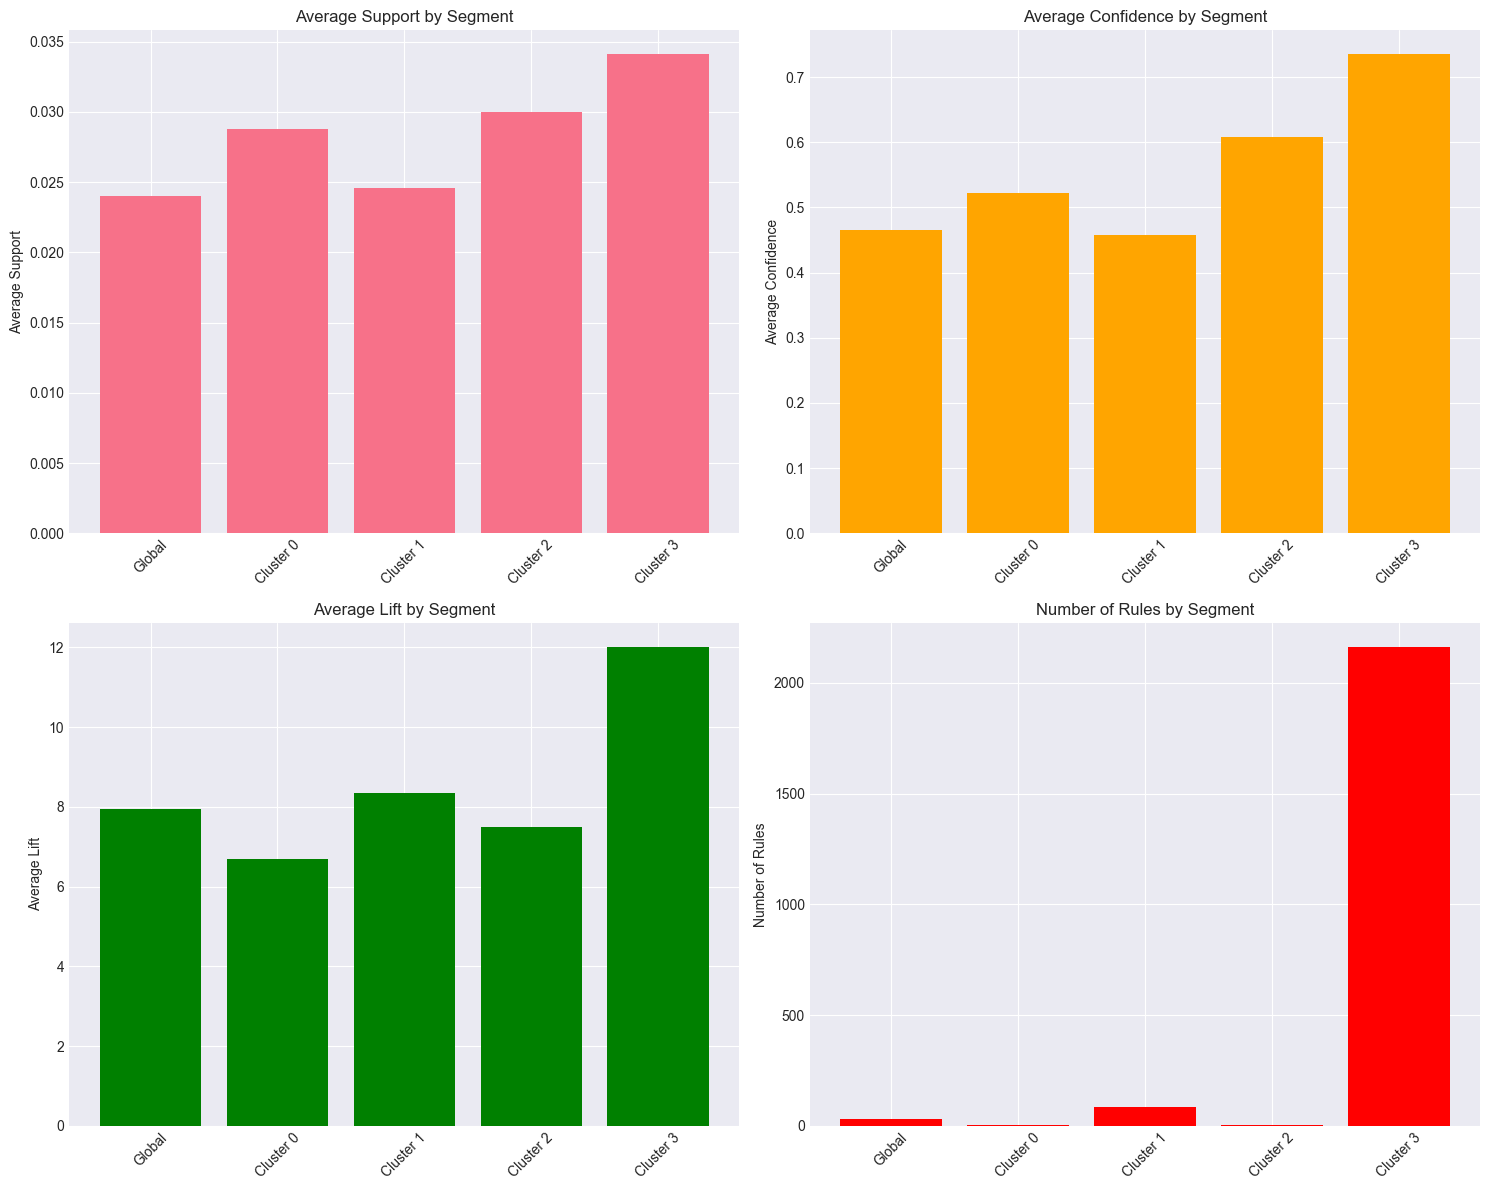

In [15]:
# Compare number of rules across segments
if global_rules is not None:
    print("Comparison of Association Rules:")
    print(f"Global Rules: {len(global_rules)}")
    for cluster_id in sorted(segment_rules.keys()):
        if cluster_id in segment_rules:
            print(f"Cluster {cluster_id} ({segment_names[cluster_id]}): {len(segment_rules[cluster_id])} rules")
    print()

# Visualize rule metrics comparison
if global_rules is not None and len(segment_rules) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Support comparison
    ax1 = axes[0, 0]
    support_data = [global_rules['support'].mean()]
    support_labels = ['Global']
    for cluster_id in sorted(segment_rules.keys()):
        if cluster_id in segment_rules:
            support_data.append(segment_rules[cluster_id]['support'].mean())
            support_labels.append(f"Cluster {cluster_id}")
    ax1.bar(support_labels, support_data)
    ax1.set_title('Average Support by Segment')
    ax1.set_ylabel('Average Support')
    ax1.tick_params(axis='x', rotation=45)
    
    # Confidence comparison
    ax2 = axes[0, 1]
    confidence_data = [global_rules['confidence'].mean()]
    confidence_labels = ['Global']
    for cluster_id in sorted(segment_rules.keys()):
        if cluster_id in segment_rules:
            confidence_data.append(segment_rules[cluster_id]['confidence'].mean())
            confidence_labels.append(f"Cluster {cluster_id}")
    ax2.bar(confidence_labels, confidence_data, color='orange')
    ax2.set_title('Average Confidence by Segment')
    ax2.set_ylabel('Average Confidence')
    ax2.tick_params(axis='x', rotation=45)
    
    # Lift comparison
    ax3 = axes[1, 0]
    lift_data = [global_rules['lift'].mean()]
    lift_labels = ['Global']
    for cluster_id in sorted(segment_rules.keys()):
        if cluster_id in segment_rules:
            lift_data.append(segment_rules[cluster_id]['lift'].mean())
            lift_labels.append(f"Cluster {cluster_id}")
    ax3.bar(lift_labels, lift_data, color='green')
    ax3.set_title('Average Lift by Segment')
    ax3.set_ylabel('Average Lift')
    ax3.tick_params(axis='x', rotation=45)
    
    # Number of rules
    ax4 = axes[1, 1]
    rule_count_data = [len(global_rules)]
    rule_count_labels = ['Global']
    for cluster_id in sorted(segment_rules.keys()):
        if cluster_id in segment_rules:
            rule_count_data.append(len(segment_rules[cluster_id]))
            rule_count_labels.append(f"Cluster {cluster_id}")
    ax4.bar(rule_count_labels, rule_count_data, color='red')
    ax4.set_title('Number of Rules by Segment')
    ax4.set_ylabel('Number of Rules')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


In [16]:
# Display top rules for each segment
if global_rules is not None:
    print("="*80)
    print("TOP 5 GLOBAL ASSOCIATION RULES")
    print("="*80)
    for idx, rule in global_rules.head(5).iterrows():
        antecedents = ', '.join(list(rule['antecedents']))
        consequents = ', '.join(list(rule['consequents']))
        print(f"\nRule: {antecedents} -> {consequents}")
        print(f"  Support: {rule['support']:.4f} | Confidence: {rule['confidence']:.4f} | Lift: {rule['lift']:.4f}")

for cluster_id in sorted(segment_rules.keys()):
    if cluster_id in segment_rules and len(segment_rules[cluster_id]) > 0:
        print(f"\n{'='*80}")
        print(f"TOP 5 ASSOCIATION RULES FOR CLUSTER {cluster_id} ({segment_names[cluster_id]})")
        print("="*80)
        for idx, rule in segment_rules[cluster_id].head(5).iterrows():
            antecedents = ', '.join(list(rule['antecedents']))
            consequents = ', '.join(list(rule['consequents']))
            print(f"\nRule: {antecedents} -> {consequents}")
            print(f"  Support: {rule['support']:.4f} | Confidence: {rule['confidence']:.4f} | Lift: {rule['lift']:.4f}")


TOP 5 GLOBAL ASSOCIATION RULES

Rule: WOODEN PICTURE FRAME WHITE FINISH -> WOODEN FRAME ANTIQUE WHITE
  Support: 0.0304 | Confidence: 0.6729 | Lift: 12.1605

Rule: WOODEN FRAME ANTIQUE WHITE -> WOODEN PICTURE FRAME WHITE FINISH
  Support: 0.0304 | Confidence: 0.5498 | Lift: 12.1605

Rule: STRAWBERRY CERAMIC TRINKET BOX -> SWEETHEART CERAMIC TRINKET BOX
  Support: 0.0320 | Confidence: 0.4746 | Lift: 11.3889

Rule: SWEETHEART CERAMIC TRINKET BOX -> STRAWBERRY CERAMIC TRINKET BOX
  Support: 0.0320 | Confidence: 0.7679 | Lift: 11.3889

Rule: HOT WATER BOTTLE TEA AND SYMPATHY -> CHOCOLATE HOT WATER BOTTLE
  Support: 0.0213 | Confidence: 0.4571 | Lift: 10.3018

TOP 5 ASSOCIATION RULES FOR CLUSTER 0 (Champions)

Rule: HEART OF WICKER SMALL -> HEART OF WICKER LARGE
  Support: 0.0279 | Confidence: 0.5106 | Lift: 7.6083

Rule: HEART OF WICKER LARGE -> HEART OF WICKER SMALL
  Support: 0.0279 | Confidence: 0.4152 | Lift: 7.6083

Rule: RED HANGING HEART T-LIGHT HOLDER -> WHITE HANGING HEART T-LIGHT

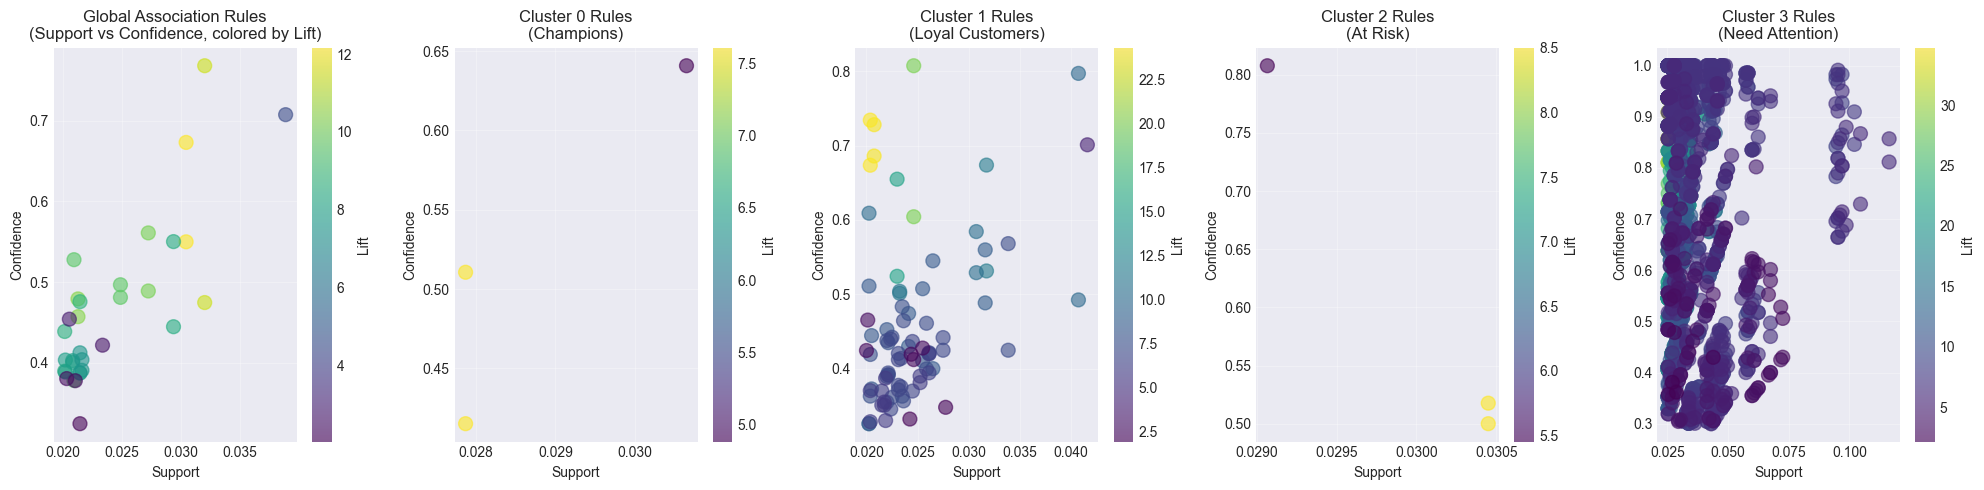

In [17]:
# Visualize scatter plot of rules (Support vs Confidence)
fig, axes = plt.subplots(1, len(segment_rules) + 1, figsize=(20, 5))
if len(segment_rules) == 0:
    axes = [axes]

# Global rules
if global_rules is not None and len(global_rules) > 0:
    ax = axes[0] if len(axes) > 1 else axes
    scatter = ax.scatter(global_rules['support'], global_rules['confidence'], 
                        c=global_rules['lift'], cmap='viridis', alpha=0.6, s=100)
    ax.set_xlabel('Support')
    ax.set_ylabel('Confidence')
    ax.set_title('Global Association Rules\n(Support vs Confidence, colored by Lift)')
    plt.colorbar(scatter, ax=ax, label='Lift')
    ax.grid(True, alpha=0.3)

# Segment rules
for idx, cluster_id in enumerate(sorted(segment_rules.keys()), 1):
    if cluster_id in segment_rules and len(segment_rules[cluster_id]) > 0:
        ax = axes[idx] if len(axes) > idx else axes[0]
        scatter = ax.scatter(segment_rules[cluster_id]['support'], 
                            segment_rules[cluster_id]['confidence'],
                            c=segment_rules[cluster_id]['lift'], cmap='viridis', alpha=0.6, s=100)
        ax.set_xlabel('Support')
        ax.set_ylabel('Confidence')
        ax.set_title(f'Cluster {cluster_id} Rules\n({segment_names[cluster_id]})')
        plt.colorbar(scatter, ax=ax, label='Lift')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 9: Business Insights and Summary


In [18]:
# Generate summary insights
print("="*80)
print("BUSINESS INSIGHTS SUMMARY")
print("="*80)

print("\n1. CUSTOMER SEGMENTATION SUMMARY:")
print("-" * 80)
for cluster_id in sorted(rfm['Cluster'].unique()):
    cluster_data = rfm[rfm['Cluster'] == cluster_id]
    char = cluster_characteristics.loc[cluster_id]
    print(f"\nCluster {cluster_id} ({segment_names[cluster_id]}):")
    print(f"  - Number of customers: {len(cluster_data)}")
    print(f"  - Average Recency: {char['Recency']:.2f} days")
    print(f"  - Average Frequency: {char['Frequency']:.2f} transactions")
    print(f"  - Average Monetary Value: £{char['Monetary']:.2f}")
    print(f"  - Total Revenue: £{cluster_data['Monetary'].sum():,.2f}")

print("\n2. ASSOCIATION RULE MINING SUMMARY:")
print("-" * 80)
if global_rules is not None:
    print(f"\nGlobal Analysis:")
    print(f"  - Total rules discovered: {len(global_rules)}")
    print(f"  - Average support: {global_rules['support'].mean():.4f}")
    print(f"  - Average confidence: {global_rules['confidence'].mean():.4f}")
    print(f"  - Average lift: {global_rules['lift'].mean():.4f}")
    
    print(f"\nSegment-Specific Analysis:")
    for cluster_id in sorted(segment_rules.keys()):
        if cluster_id in segment_rules:
            rules = segment_rules[cluster_id]
            print(f"\n  Cluster {cluster_id} ({segment_names[cluster_id]}):")
            print(f"    - Rules discovered: {len(rules)}")
            print(f"    - Average support: {rules['support'].mean():.4f}")
            print(f"    - Average confidence: {rules['confidence'].mean():.4f}")
            print(f"    - Average lift: {rules['lift'].mean():.4f}")

print("\n3. KEY FINDINGS:")
print("-" * 80)
print("  - Different customer segments exhibit distinct purchasing patterns")
print("  - Segment-specific rules provide more targeted insights than global rules")
print("  - High-value segments may have different product affinities")
print("  - Rules can be used for personalized recommendations and targeted marketing")

print("\n4. RECOMMENDATIONS:")
print("-" * 80)
print("  - Use segment-specific rules for personalized product recommendations")
print("  - Develop targeted marketing campaigns based on segment characteristics")
print("  - Optimize inventory based on segment-specific product associations")
print("  - Focus retention efforts on high-value segments with specific product bundles")


BUSINESS INSIGHTS SUMMARY

1. CUSTOMER SEGMENTATION SUMMARY:
--------------------------------------------------------------------------------

Cluster 0 (Champions):
  - Number of customers: 1955
  - Average Recency: 52.45 days
  - Average Frequency: 2.20 transactions
  - Average Monetary Value: £491.95
  - Total Revenue: £961,758.63

Cluster 1 (Loyal Customers):
  - Number of customers: 1261
  - Average Recency: 33.57 days
  - Average Frequency: 8.60 transactions
  - Average Monetary Value: £3029.41
  - Total Revenue: £3,820,084.96

Cluster 2 (At Risk):
  - Number of customers: 958
  - Average Recency: 247.72 days
  - Average Frequency: 1.51 transactions
  - Average Monetary Value: £345.10
  - Total Revenue: £330,603.66

Cluster 3 (Need Attention):
  - Number of customers: 12
  - Average Recency: 3.75 days
  - Average Frequency: 98.83 transactions
  - Average Monetary Value: £33880.10
  - Total Revenue: £406,561.14

2. ASSOCIATION RULE MINING SUMMARY:
---------------------------------

## Conclusion

This notebook successfully implemented a two-tier analytics pipeline that:
1. **Segmented customers** using RFM analysis and K-means clustering
2. **Mined association rules** both globally and per customer segment
3. **Compared patterns** across segments to identify unique purchasing behaviors
4. **Generated actionable insights** for targeted marketing and inventory optimization

The integration of customer segmentation with association rule mining provides a more nuanced understanding of customer behavior, enabling retailers to make data-driven decisions for personalized marketing and product recommendations.
